In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train = pd.read_csv('train.csv')
train.head()

,filename,category
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3
2,f6c172096818c5fab10ecae722840798.jpg,3
3,251ffd610399ac00fea7709c642676ee.jpg,3
4,73c7328b8eda399199fdedec6e4badaf.jpg,3


In [5]:
train.groupby('category').count().T

category,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
filename,2683,2702,2687,2703,2703,2641,2641,2660,2700,2698,...,2157,573,2599,2658,2686,1725,2673,2678,2681,2662


In [6]:
min_class = train.groupby('category').count().min()[0]
type(min_class)

numpy.int64

In [7]:
balanced_train = train.groupby('category').apply(lambda x: x.sample(n=min_class, random_state=0))
balanced_train.head()

filename  category
category                                                      
0        53627  319a832db9df6a48f131ca5be7c8cf8a.jpg         0
         54004  f32b54fd66ffa0ac7f63e4bcfa352f11.jpg         0
         54935  61ad8bf6f8559d7fb7a1588bfb26b899.jpg         0
         53811  e73b77ba84394840a5ba34d42cfc91ad.jpg         0
         54890  349b2890aba91ffec43c4d7e293970e1.jpg         0

In [8]:
del balanced_train['category']

In [9]:
balanced_train.groupby('category').count().T

category,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
filename,573,573,573,573,573,573,573,573,573,573,...,573,573,573,573,573,573,573,573,573,573


In [10]:
balanced_train.head()

filename
category                                            
0        53627  319a832db9df6a48f131ca5be7c8cf8a.jpg
         54004  f32b54fd66ffa0ac7f63e4bcfa352f11.jpg
         54935  61ad8bf6f8559d7fb7a1588bfb26b899.jpg
         53811  e73b77ba84394840a5ba34d42cfc91ad.jpg
         54890  349b2890aba91ffec43c4d7e293970e1.jpg

In [11]:
balanced_train = balanced_train.reset_index()
del balanced_train['level_1']
balanced_train.head()

,category,filename
0,0,319a832db9df6a48f131ca5be7c8cf8a.jpg
1,0,f32b54fd66ffa0ac7f63e4bcfa352f11.jpg
2,0,61ad8bf6f8559d7fb7a1588bfb26b899.jpg
3,0,e73b77ba84394840a5ba34d42cfc91ad.jpg
4,0,349b2890aba91ffec43c4d7e293970e1.jpg


In [12]:
balanced_train.to_csv('balanced.csv', index=False)

In [13]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [14]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [15]:
train_dir = 'train/train'

In [16]:
train_data_gen = train_image_generator.flow_from_directory(
                                                           batch_size=batch_size,  
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           seed=0,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 105392 images belonging to 42 classes.


In [17]:
sample_training_images, _ = next(train_data_gen)

In [18]:
sample_training_images[:5].shape

(5, 150, 150, 3)

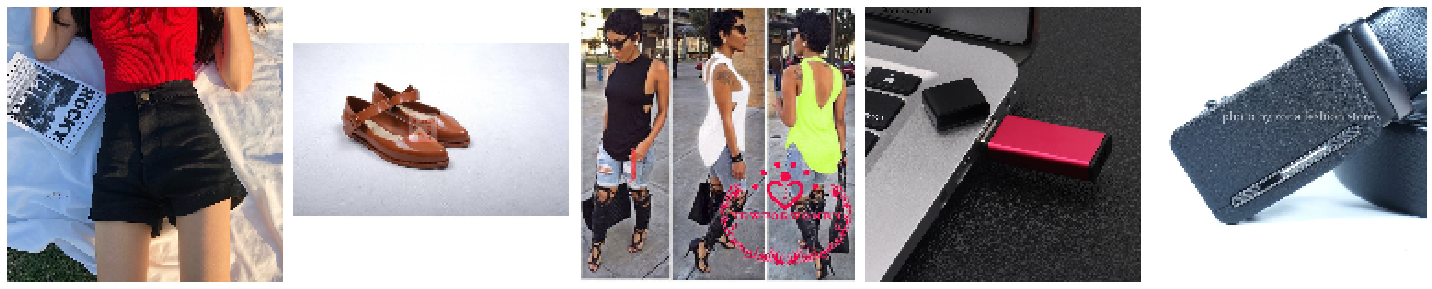

In [19]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

In [20]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
history = model.fit_generator(
    train_data_gen,
    epochs=epochs,
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
 30/824 [>.............................] - ETA: 20:05 - loss: 0.1883 - accuracy: 0.9762

KeyboardInterrupt: 

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]